<a href="https://colab.research.google.com/github/yy0750/Stock-Price-Prediction-using-HMM-and-ARIMA/blob/main/GMMHMM_ARIMA_Stoc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Appendix A.1. Preparation for Model Construction/Modeling

#### Appendix A.1.1. Importing Necessary Modeules

In [1]:
!pip install hmmlearn
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.1/161.1 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 6.5 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import yfinance as yf
import pmdarima as pm
from hmmlearn import hmm
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import ndiffs
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

In [3]:
start_date = '2021-12-10'
end_date = '2023-11-17'

stock_code = '005930.KS' #Sk하이닉스: '000660.KS'
df = yf.download(stock_code, start=start_date, end=end_date)
df.reset_index(inplace=True)

df.insert(0, 'ID', df.index)
df.drop('Adj Close', axis=1, inplace=True)

[*********************100%%**********************]  1 of 1 completed


In [4]:
df.head()

,ID,Date,Open,High,Low,Close,Volume
0,0,2021-12-10,77400.0,77600.0,76800.0,76900.0,9155219
1,1,2021-12-13,77200.0,78300.0,76500.0,76800.0,15038750
2,2,2021-12-14,76500.0,77200.0,76200.0,77000.0,10976660
3,3,2021-12-15,76400.0,77600.0,76300.0,77600.0,9584939
4,4,2021-12-16,78500.0,78500.0,77400.0,77800.0,11996128


### Appendix A.1.3 Data formatting and Normalization

In [5]:
df['Avg'] = pd.Series([((row.Open + row.High + row.Low + row.Close)/4) for index, row in df.iterrows()])
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')

X = df.values[:, [0, 7]]
X = np.nan_to_num(X)
X = StandardScaler().fit_transform(X)

#### Appendix A.1.4 Clustering
###### K-Means Clustering
###### Preliminary Clustering

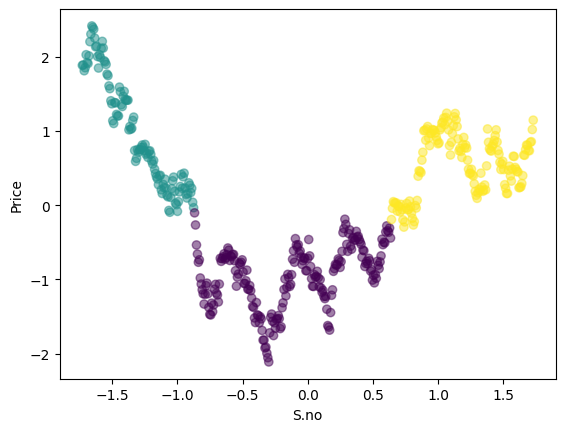

In [6]:
clusterNum = 3
k_means = KMeans(init = 'k-means++', n_clusters = clusterNum, n_init = 12)
k_means.fit(X)
labels = k_means.labels_

df['State'] = labels

plt.scatter(X[:, 0], X[:, 1], c=labels.astype(np.float64), alpha=0.5);
plt.xlabel('S.no');
plt.ylabel('Price');

In [7]:
pre_means = []
pre_covars = []

for i in [0, 1, 2]:
    tdf = df[df.State == i]

    pre_means.append(tdf['Avg'].sum() / tdf['Avg'].count())
    pre_covars.append(tdf['Avg'].std() ** 2)

##### Clustering the log-likelihoods


In [11]:
pre_prices = df['Avg'].tolist()

pre_training_ll = [np.nan] * len(pre_prices)

for i in range(3, len(pre_prices)): #Method 1
#for i in range(len(pre_prices)): #Method 2
    print('Datapoint: ', i)
    #Initialize
    pre_model = hmm.GMMHMM(n_components = 3, n_mix=1, n_iter = 100, covariance_type='diag', init_params='')
    pre_model.startprob_ = np.array([1/3, 1/3, 1/3])
    pre_model.transmat_ = np.array([[1/3, 1/3, 1/3], [1/3, 1/3, 1/3], [1/3, 1/3, 1/3]])
    pre_model.means_ = np.array([pre_means[0], pre_means[1], pre_means[2]]).reshape(3, 1)
    pre_model.covars_ = np.array([pre_covars[0], pre_covars[1], pre_covars[2]]).reshape(3, 1)
    pre_model.weights_ = np.array([1, 1, 1]).reshape(3,1)

    #Samples
    X = np.array(pre_prices[max(i-4, 0):i]).reshape(i - max(i-4, 0), 1)

    #Method 2
    #X = np.array([df['Open'][i], df['Close'][i], df['High'][i], df['Low'][i]]).reshape(4, 1)

    X = np.nan_to_num(X)

    # Training
    try:
        pre_model.fit(X)
    except ValueError:
        continue

    pre_training_ll[i] = pre_model.monitor_.history[0]

df['pre_ll'] = np.nan_to_num(pre_training_ll)

##### Refining the clusters (Clustering the log_likelihoods):

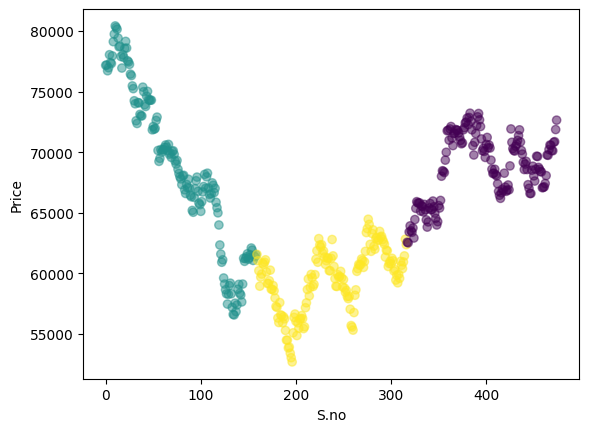

In [9]:
X = df.values[3:, [0, 9]] #Method 1
#X = df.values[:, [0, 9]] #Method 2
X = np.nan_to_num(X)
X = StandardScaler().fit_transform(X)

clusterNum = 3
k_means = KMeans(init = 'k-means++', n_clusters = clusterNum, n_init = 12)
k_means.fit(X)
labels = k_means.labels_

#세 개의 행 삭제
df = df.drop([0, 1, 2]) #Method 1

df['State'] = labels

plt.scatter(df['ID'], df['Avg'], c=df['State'].astype(np.float64), alpha=0.5);
plt.xlabel('S.no');
plt.ylabel('Price');

## Appendix A.2. Model Construction/Modeling


#### Appendix A.2.1 Mixture Model
##### Low Economy

<ipython-input-18-18094e1c0f12>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_df.drop(['ID'], axis=1, inplace=True)
<ipython-input-18-18094e1c0f12>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_df['ID'] = low_df.index
<ipython-input-18-18094e1c0f12>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_df['Mix

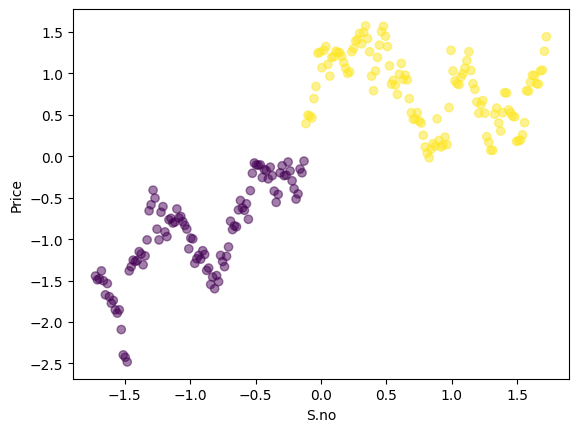

In [ ]:
low_df = df[df.State == 0]

low_df.reset_index(inplace=True)
low_df.drop(['ID'], axis=1, inplace=True)
low_df['ID'] = low_df.index

X = low_df.values[:, [10, 7]]
X = np.nan_to_num(X)
X = StandardScaler().fit_transform(X)

clusterNum = 2
low_k_means = KMeans(init='k-means++', n_clusters=clusterNum, n_init=12)
low_k_means.fit(X)
labels = low_k_means.labels_
low_df['Mix'] = labels

plt.scatter(X[:, 0], X[:, 1], c=labels.astype(np.float64), alpha=0.5);
plt.xlabel('S.no');
plt.ylabel('Price');

low_means = []
low_covars = []
low_weights = []

for i in [0, 1]:
    tdf = low_df[low_df.Mix == i]

    #Mean
    low_means.append(tdf['Avg'].sum() / tdf['Avg'].count())

    #Variance
    low_covars.append(tdf['Avg'].std() ** 2)

    #Weights
    tdf = low_df[low_df.Mix == 0]
    low_weights.append(tdf['Avg'].count() / low_df['Avg'].count())
    low_weights.append(1 - low_weights[0])

##### Medium Economy

<ipython-input-19-9acbba666d0d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  medium_df.drop(['ID'], axis=1, inplace=True)
<ipython-input-19-9acbba666d0d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  medium_df['ID'] = medium_df.index
<ipython-input-19-9acbba666d0d>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  me

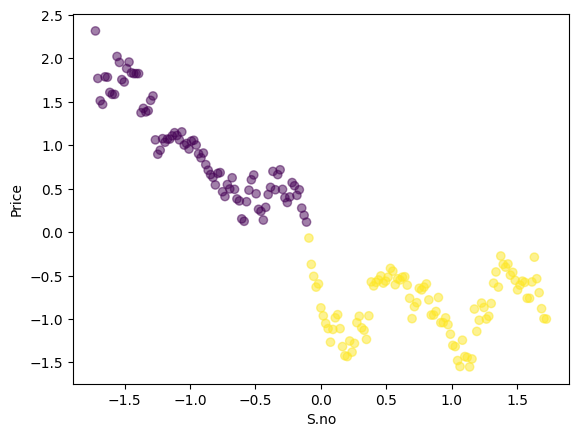

In [ ]:
medium_df = df[df.State == 2]

medium_df.reset_index(inplace=True)
medium_df.drop(['ID'], axis=1, inplace=True)
medium_df['ID'] = medium_df.index

X = medium_df.values[:, [10, 7]]
X = np.nan_to_num(X)
X = StandardScaler().fit_transform(X)

clusterNum = 2
medium_k_means = KMeans(init='k-means++', n_clusters=clusterNum, n_init=12)
medium_k_means.fit(X)
labels = medium_k_means.labels_
medium_df['Mix'] = labels

plt.scatter(X[:, 0], X[:, 1], c=labels.astype(np.float64), alpha=0.5)
plt.xlabel('S.no')
plt.ylabel('Price')

medium_means = []
medium_covars = []
medium_weights = []

for i in [0, 1]:
    tdf = medium_df[medium_df.Mix == i]

    #Mean
    medium_means.append(tdf['Avg'].sum() / tdf['Avg'].count())

    #Variance
    medium_covars.append(tdf['Avg'].std() ** 2)

    #Weights
    tdf = medium_df[medium_df.Mix == 0]
    medium_weights.append(tdf['Avg'].count() / medium_df['Avg'].count())
    medium_weights.append(1 - medium_weights[0])

##### High Economy

<ipython-input-20-5f15762a6f4f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_df.drop(['ID'], axis=1, inplace=True)
<ipython-input-20-5f15762a6f4f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_df['ID'] = high_df.index
<ipython-input-20-5f15762a6f4f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_df[

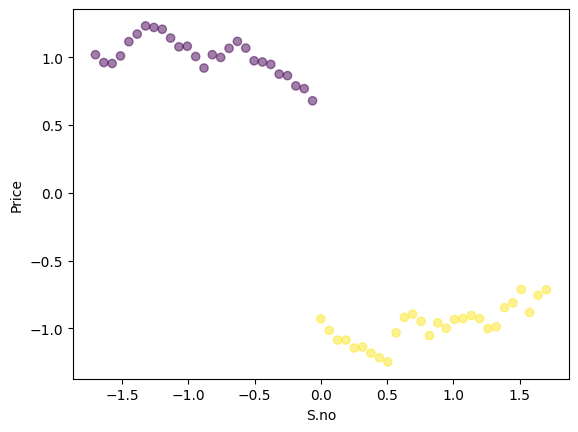

In [ ]:
high_df = df[df.State == 1]

high_df.reset_index(inplace=True)
high_df.drop(['ID'], axis=1, inplace=True)
high_df['ID'] = high_df.index

X = high_df.values[:, [10, 7]]
X = np.nan_to_num(X)
X = StandardScaler().fit_transform(X)

clusterNum = 2
high_K_means = KMeans(init = 'k-means++', n_clusters = clusterNum, n_init = 12)
high_K_means.fit(X)
labels = high_K_means.labels_
high_df['Mix'] = labels

plt.scatter(X[:, 0], X[:, 1], c=labels.astype(np.float64), alpha=0.5)
plt.xlabel('S.no')
plt.ylabel('Price')

high_means = []
high_covars = []
high_weights = []

for i in [0, 1]:
    tdf = high_df[high_df.Mix == i]

    #Mean
    high_means.append(tdf['Avg'].sum() / tdf['Avg'].count())

    #Variance
    high_covars.append(tdf['Avg'].std() ** 2)

    #Weights
    tdf = high_df[high_df.Mix == 0]
    high_weights.append(tdf['Avg'].count() / high_df['Avg'].count())
    high_weights.append(1 - high_weights[0])

#### Appendix A.2.2 HMM Training and Testing

In [ ]:
prices = df['Close'].tolist()

training_ll = [None] * len(prices)
lls = [None] * len(prices)
predicted_prices = [None] * (len(prices)+1)
epsilon = 0.2
curr_ll = 0

for i in range(3, len(prices)): #{for i in range(len(prices)):} - Method 2
    print('Datapoint: ', i)
    #Initialize
    model = hmm.GMMHMM(n_components=3, n_mix=2, n_iter=100, covariance_type='diag', init_params='')
    model.startprob_ = np.array([1/3, 1/3, 1/3])
    model.transmat_ = np.array([[1/3, 1/3, 1/3], [1/3, 1/3, 1/3], [1/3, 1/3, 1/3]])

    model.means_ = np.array([[medium_means[0], medium_means[1]], [high_means[0], high_means[1]], [low_means[0], low_means[1]]]).reshape(3, 2, 1)
    model.covars_ = np.array([[medium_covars[0], medium_covars[1]], [high_covars[0], high_covars[1]], [low_covars[0], low_covars[1]]]).reshape(3, 2, 1)
    model.weights_ = np.array([[medium_weights[0], medium_weights[1]], [high_weights[0], high_weights[1]], [low_weights[0], low_weights[1]]])

    #Samples
    X = np.array(prices[max(i-4, 0):i]).reshape(i - max(i-4, 0),1)

    #Method 2
    #X = np.array([df['Open'][i], df['Close'][i], df['High'][i], df['Low'][i]]).reshape(4, 1)
    X = np.nan_to_num(X)

    #Training
    try:
        model.fit(X)
    except ValueError:
        pass


    ll_arr = np.array(model.monitor_.history)
    ll_arr = ll_arr[~np.isnan(ll_arr)]

    # Log-likelihood
    try:
        #curr_ll = ll_arr[0] # - First Iteration
        #curr_ll = np.median(ll_arr) # - Middle Iteration
        curr_ll = ll_arr[-1] # - Last Iteration
    except ValueError:
        pass

    lls[i] = (curr_ll)

    #Predict
    if i > 427:
        diff = []
        for j in range(3, i): #{for j in range(i):} - Method 2
            if lls[j] != None:
                if lls[j] < (curr_ll + epsilon) and lls[j] > (curr_ll - epsilon):
                    diff.append(prices[j+1] - prices[j])

        if len(diff) > 0:
            min_diff = diff[np.argmin(np.abs(diff))]
            predicted_prices[i+1] = prices[i] + min_diff

df['PredictedPrices'] = pd.Series(predicted_prices)

#### Appendix A.2.3 Model Performance

<ipython-input-25-24a113415881>:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  plt.plot(df[df['Date'] > '31-08-2023']['Close'], label='Actual Prices', c='b')


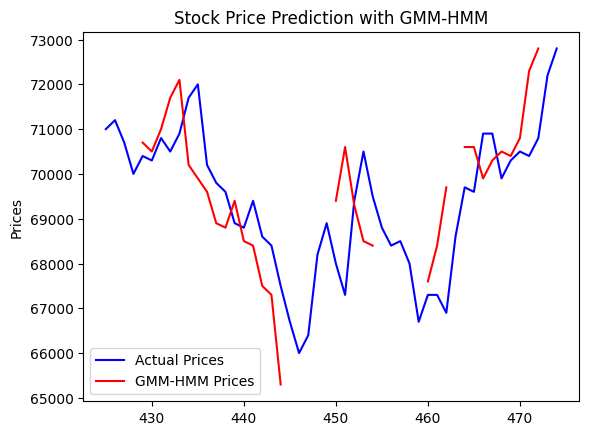

MAPE:  1.715194667698454


In [ ]:
#Plot
plt.plot(df[df['Date'] > '31-08-2023']['Close'], label='Actual Prices', c='b')
plt.plot(df['PredictedPrices'], label='GMM-HMM Prices', c='r')
plt.title('Stock Price Prediction with GMM-HMM')
plt.ylabel('Prices')
plt.legend()
plt.show()

#Metrics
y_true = df[~np.isnan(df['PredictedPrices'])]['Close'].tolist()  # 실제 주가
y_pred = df[~np.isnan(df['PredictedPrices'])]['PredictedPrices'].tolist()  # GMM-HMM 모델로 예측한 주가

mape = metrics.mean_absolute_percentage_error(y_true, y_pred) * 100
print('MAPE: ', mape)


# ARIMA

#### 1.1 Data

In [ ]:
start_date = '2021-12-10'
end_date = '2023-11-17'

stock_code = '005930.KS' #Sk하이닉스: '00660.KS'
df = yf.download(stock_code, start=start_date, end=end_date)

data = df['Adj Close'][df['Volume'] != 0]

[*********************100%%**********************]  1 of 1 completed


#### 1.2 plot rolling

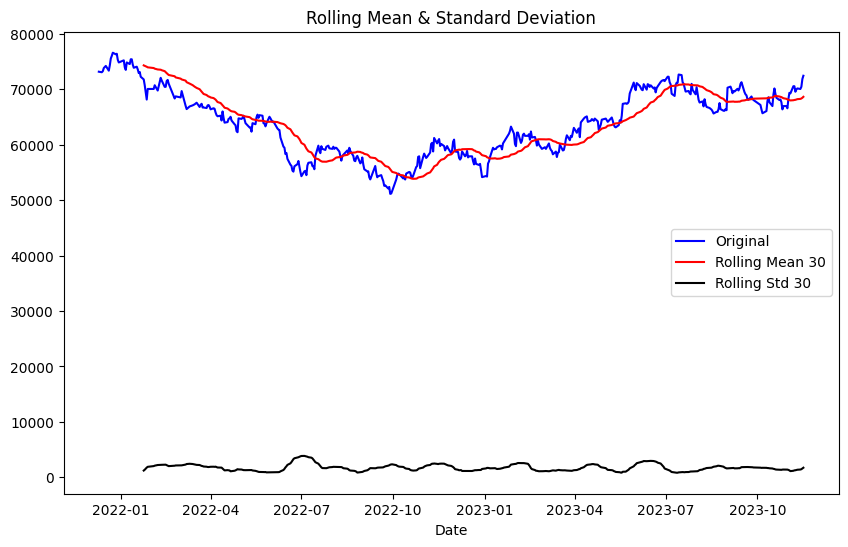

In [ ]:
def plot_rolling(data, interval):
    rolmean = data.rolling(interval).mean()
    rolstd = data.rolling(interval).std()
    #Plot rolling statistics:
    plt.figure(figsize=(10, 6))
    plt.xlabel('Date')
    orig = plt.plot(data, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean {}'.format(interval))
    std = plt.plot(rolstd, color='black', label = 'Rolling Std {}'.format(interval))
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

plot_rolling(data, 30)

#### 2.1 ADF Test

In [ ]:
def adf_test(data):
    result = adfuller(data.values)
    print('ADF Statistics: %f' % result[0])
    print('p-value: %f' % result[1])
    print('num of lags: %f' % result[2])
    print('num of observations: %f' % result[3])
    print('Critical values:')
    for k, v in result[4].items():
        print('\t%s: %.3f' % (k,v))

print('ADF TEST RESULT')
adf_test(data)

ADF TEST RESULT
ADF Statistics: -1.472993
p-value: 0.546827
num of lags: 2.000000
num of observations: 461.000000
Critical values:
	1%: -3.445
	5%: -2.868
	10%: -2.570


#### 2.2Intergrated

<Axes: xlabel='Date'>

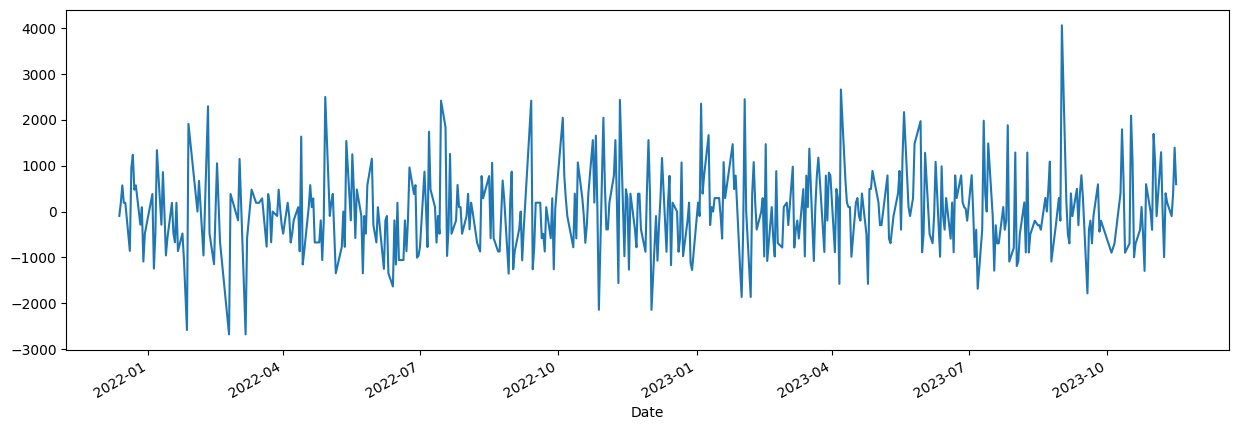

In [ ]:
dff1 = data.diff().dropna()
dff1.plot(figsize=(15,5))

In [ ]:
adf_test(dff1)

ADF Statistics: -17.501348
p-value: 0.000000
num of lags: 1.000000
num of observations: 461.000000
Critical values:
	1%: -3.445
	5%: -2.868
	10%: -2.570


#### 2.3 ARIMA(p,d,q) parameter

In [ ]:
data = df['Close']
n_diffs = ndiffs(data, alpha=0.05, test='adf', max_d=6)
print(f"d = {n_diffs}")

d = 1


In [ ]:
model = pm.auto_arima(
            y=data,
            d=1,
            start_p=0, max_p=3,
            start_q=0, max_q=3,
            m=1, seasonal=False,
            stepwise=True,
            trace=True
)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7804.218, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7806.026, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7806.029, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7802.263, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=7807.794, Time=0.50 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.870 seconds


3.1 Fit Train Data

In [ ]:
train_data, test_data = data[:int(len(data)*0.9)], data[int(len(data)*0.9):]

model_fit = pm.auto_arima(
    	    y=train_data,
 	        d=n_diffs ,
            start_p=0, max_p=2,
            start_q=0, max_q=2,
            m=1, seasonal=False,
            stepwise=True,
            trace=True
)
print(model_fit.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7021.434, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7023.078, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7023.079, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7019.526, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=7024.887, Time=0.63 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.978 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  427
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -3508.763
Date:                Wed, 06 Mar 2024   AIC                           7019.526
Time:                        16:31:18   BIC                           7023.581
Sample:                             0   HQIC                          7021.128
                                - 427                                       

#### 3.2 Forecast Function

In [ ]:
def forecast_n_step(model, n = 1):
    fc, conf_int = model.predict(n_periods=n, return_conf_int=True)
    # print("fc", fc,"conf_int", conf_int)
    return (
        fc.tolist()[0:n], np.asarray(conf_int).tolist()[0:n]
   )

def forecast(len, model, index, data=None):
    y_pred = []
    pred_upper = []
    pred_lower = []

    if data is not None:
        for new_ob in data:
            fc, conf = forecast_n_step(model)
            y_pred.append(fc[0])
            pred_upper.append(conf[0][1])
            pred_lower.append(conf[0][0])
            model.update(new_ob)
    else:
        for i in range(len):
            fc, conf = forecast_n_step(model)
            y_pred.append(fc[0])
            pred_upper.append(conf[0][1])
            pred_lower.append(conf[0][0])
            model.update(fc[0])
    return pd.Series(y_pred, index=index), pred_upper, pred_lower

#### 3.3 Forecast

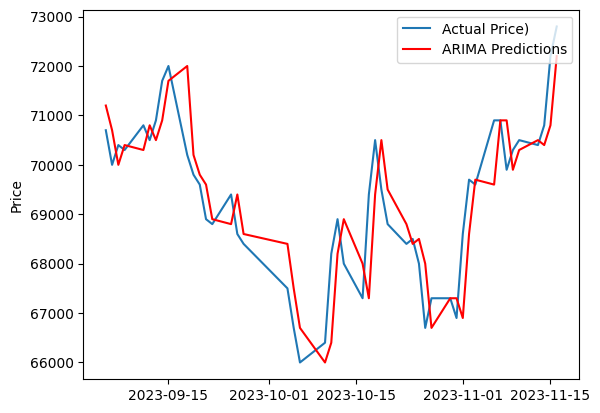

In [ ]:
fc, upper, lower = forecast(len(test_data), model_fit, test_data.index, data = test_data)

plt.plot(test_data, label='Actual Price)')
plt.plot(fc, color='red',label='ARIMA Predictions')
plt.ylabel('Price')
plt.legend(loc='upper right')
plt.show()

#### 4.1 Model Performance

In [ ]:
log_test_data = np.log(test_data)
log_fc = np.log(fc)

mape = np.mean(np.abs(np.exp(log_fc) - np.exp(log_test_data)) / np.abs(np.exp(log_test_data)))
print('MAPE: ', '{:.5f}%'.format(mape * 100))

mape = metrics.mean_absolute_percentage_error(test_data, fc) * 100
print('MAPE: ', mape)

MAPE:  0.96883%
MAPE:  0.9688288988216353
